In [1]:
import torch
import pandas as pd
import numpy as np
import sys

sys.path.insert(0, "../pipeline/")
import preprocessing
import utils
import matplotlib.pyplot as plt
import json

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from gcn import GCNModel
from torch_geometric.data import Data
from matplotlib import rcParams

In [2]:
torch.manual_seed(0)
np.random.seed(0)

profiles = pd.read_csv("../data/new_profiles_200t.csv")
comments = pd.read_csv("../data/new_comments_200t.csv")

comments = comments.drop_duplicates()
profiles = preprocessing.categorical_to_numerical(profiles, col="category_1")
all_users = set(profiles.profile_username.values)

data = preprocessing.scale(profiles.drop(columns=["category_1", "profile_username"]).values)
name_to_record = {name: record for name, record in zip(all_users, data)}

input_dim, output_dim = data.shape[1], len(profiles.category_1.unique()) + 1
user_to_label = {user: category for user, category in profiles[["profile_username", "category_1"]].values}

In [3]:
authors = profiles.profile_username.values

username_to_index = utils.get_users_indices(authors)
interactions = utils.get_interactions(comments[comments.media_author.isin(authors) & comments.commenter.isin(authors)], username_to_index)
x, y = utils.get_x(authors, name_to_record, input_dim=input_dim), utils.get_y(user_to_label, authors)

edge_index = utils.get_edge_index(interactions)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = Data(x=x, y=y, edge_index=edge_index).to(device)

gcn = GCNModel(x.shape[1], 64, 5, lr=0.005, n_hidden_layers=2)
history = gcn.fit(data, epochs=100)

embeddings = gcn.forward(data.x, data.edge_index, apply_activation=False)

---> (1/100) Running loss: 1.6746314764022827
---> (2/100) Running loss: 1.4904470443725586
---> (3/100) Running loss: 1.4438430070877075
---> (4/100) Running loss: 1.4253123998641968
---> (5/100) Running loss: 1.4152958393096924
---> (6/100) Running loss: 1.4089057445526123
---> (7/100) Running loss: 1.4018458127975464
---> (8/100) Running loss: 1.3929702043533325
---> (9/100) Running loss: 1.381588339805603
---> (10/100) Running loss: 1.3684884309768677
---> (11/100) Running loss: 1.3540241718292236
---> (12/100) Running loss: 1.338917851448059
---> (13/100) Running loss: 1.324125051498413
---> (14/100) Running loss: 1.3099943399429321
---> (15/100) Running loss: 1.296974539756775
---> (16/100) Running loss: 1.285631537437439
---> (17/100) Running loss: 1.274461030960083
---> (18/100) Running loss: 1.2626692056655884
---> (19/100) Running loss: 1.2503187656402588
---> (20/100) Running loss: 1.2377372980117798
---> (21/100) Running loss: 1.2246167659759521
---> (22/100) Running loss: 

In [4]:
category1 = profiles[profiles.category_1 == 1].index.values
category2 = profiles[profiles.category_1 == 2].index.values
category3 = profiles[profiles.category_1 == 3].index.values
category4 = profiles[profiles.category_1 == 4].index.values

group_indices = [category1, category2, category3, category4]

In [5]:
def reduce_data(data, n_dim=2):
    return PCA(n_components=n_dim, random_state=0).fit_transform(data)


def plot_2d(data, group_indices, legends):
    for group in group_indices:
        plt.scatter(data[group][:, :1], data[group][:, 1:])
    plt.legend(legends)
    plt.show()
    

def plot_3d(data, group_indices, legends):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for group in group_indices:
        ax.scatter(data[group][:, :1], data[group][:, 1:2], data[group][:, 2:])
    plt.legend(legends)
    plt.show()

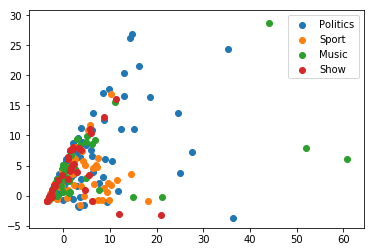

In [6]:
data = reduce_data(embeddings.detach().numpy(), n_dim=2)
plot_2d(data, group_indices, ["Politics", "Sport", "Music", "Show"])

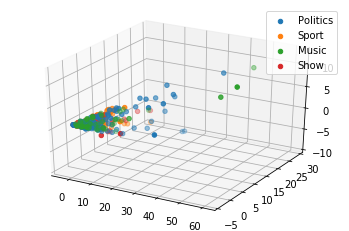

In [7]:
data = reduce_data(embeddings.detach().numpy(), n_dim=3)
plot_3d(data, group_indices, ["Politics", "Sport", "Music", "Show"])

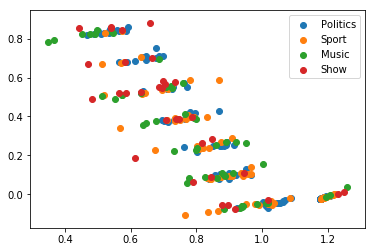

In [8]:
data = preprocessing.scale(profiles.drop(columns=["category_1", "profile_username"]).values)
data = reduce_data(data, n_dim=2)
plot_2d(data, group_indices, ["Politics", "Sport", "Music", "Show"])

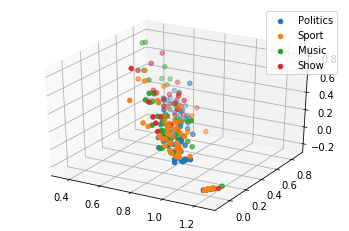

In [9]:
data = preprocessing.scale(profiles.drop(columns=["category_1", "profile_username"]).values)
data = reduce_data(data, n_dim=3)
plot_3d(data, group_indices, ["Politics", "Sport", "Music", "Show"])

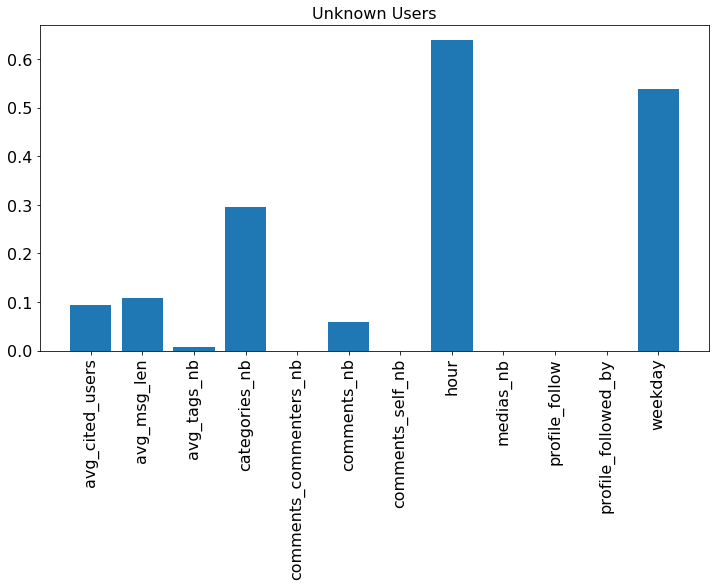

In [10]:
rcParams["figure.figsize"] = (12, 6)
category_to_numerical = {"Unknown Users": 0, "Politics": 1, "Sport": 2, "Music": 3, "Show": 4}

df_values = profiles.drop(["profile_username"], axis=1)
df_category = df_values[df_values.category_1 == category_to_numerical["Unknown Users"]]
df_category = pd.DataFrame(preprocessing.scale(df_category.values), columns=df_category.columns)\
                    .drop(["category_1", "is_tracked"], axis=1)

x = df_category.columns
y = []
for col in x:
    y.append(np.mean(df_category[col].values))

plt.bar(x, y)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.title("Unknown Users", fontsize=16)
plt.show()

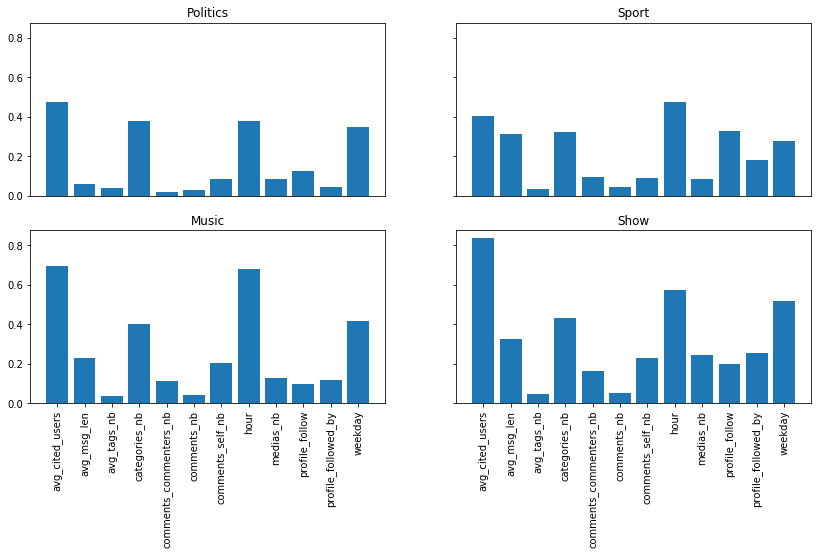

In [11]:
df_values = profiles.drop(["profile_username"], axis=1)
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(14, 7))
for i, category in enumerate(["Politics", "Sport", "Music", "Show"]):    
    df_category = df_values[df_values.category_1 == category_to_numerical[category]]
    df_category = pd.DataFrame(preprocessing.scale(df_category.values), columns=df_category.columns)\
                        .drop(["category_1", "is_tracked"], axis=1)

    x = df_category.columns
    y = []
    for col in x:
        y.append(np.mean(df_category[col].values))
    
    axes[i//2, i%2].bar(x, y)
    axes[i//2, i%2].set_title(category)
    
    if i//2 != 1:
        axes[i//2, i%2].set_xticks([])
    for tick in axes[i//2, i%2].get_xticklabels():
        tick.set_rotation(90)

plt.show()

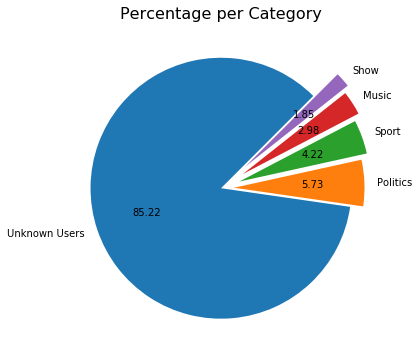

In [12]:
legends = ["Unknown Users", "Politics", "Sport", "Music", "Show"]
values = profiles[["category_1", "profile_username"]].groupby("category_1").count().values

plt.pie(values, labels=legends, autopct="%.2f", startangle=45, explode=[0, 0.1, 0.15, 0.2, 0.25])
plt.title("Percentage per Category", fontsize=16)
rcParams["font.size"] = 14
plt.show()

In [13]:
gcn_trace = json.load(open("../data/results/histories/models_histories_100e_2l_64u.json"))["GCNModel"]

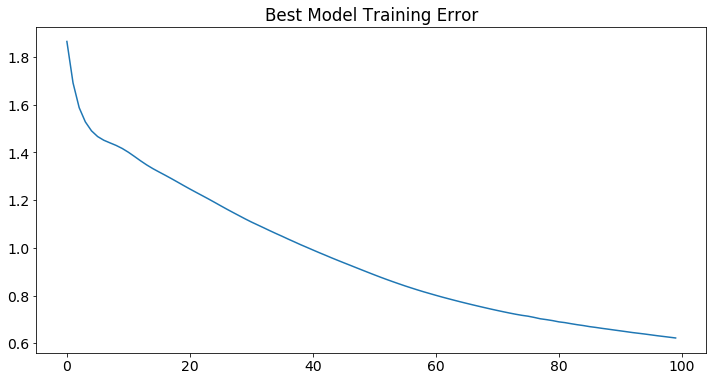

In [14]:
plt.plot(range(len(gcn_trace)), gcn_trace)
plt.title("Best Model Training Error")
plt.show()

In [15]:
y = profiles.category_1.values
x = profiles.drop(["category_1", "profile_username"], axis=1).values

In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

f1s = []
skf = StratifiedKFold(n_splits=5)
for train_idx, test_idx in skf.split(x, y):
    xgb = XGBClassifier()
    xgb.fit(x[train_idx], y[train_idx])
    y_pred = xgb.predict(x[test_idx])
    
    f1s.append(f1_score(y[test_idx], y_pred, average="macro"))

print(np.mean(f1s), np.std(f1s))

0.696721002954871 0.036289000810455926


usar treino no teste para achar o erro

In [55]:
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss, NLLLoss
from sklearn.metrics import classification_report


class LinearModel(nn.Module):
    def __init__(self, in_dim, out_dim, lr=0.0001):
        super(LinearModel, self).__init__()
        self.m = nn.Sequential(*[nn.Linear(in_dim, 100),
                                nn.ReLU(),
                                nn.Linear(100, 300),
                                nn.ReLU(),
                                nn.Linear(300, 100),
                                nn.ReLU(),
                                nn.Linear(100, 100),
                                nn.ReLU(),
                                nn.Linear(100, out_dim),
                                nn.Softmax(dim=1)])
        
        self.criterion = CrossEntropyLoss()
        self.optimizer = Adam(self.parameters(), lr=lr)
    
    def forward(self, x):
        return self.m(x)
    
    def fit(self, x, y_true, n_epochs=10):
        for epoch in range(n_epochs):
            self.optimizer.zero_grad()
            y_preds = self.forward(x)
            
            print(y_preds[:10], y_true[:10])
            loss = self.criterion(y_preds, y_true)
            loss.backward()
            self.optimizer.step()
            print("{}/{} Running Loss: {}".format(epoch+1, n_epochs, loss.item()))

In [56]:
data = open("../data/64e.emb").read().split('\n')[1:-1]
data = [(int(row.split()[0]), row.split()[1:]) for row in data]

indices = [index for index, _ in data]

# y = torch.Tensor(profiles.iloc[indices].category_1.values).long()
# x = preprocessing.scale(profiles.iloc[indices].drop(["profile_username", "category_1"], axis=1).values)
y = torch.Tensor(profiles[profiles.is_tracked == 1].category_1.values).long()
x = preprocessing.scale(profiles[profiles.is_tracked == 1].drop(["profile_username"], axis=1).values)
x = torch.Tensor(x)

# data = torch.Tensor([list(map(float, embeds)) for index, embeds in sorted(data)])

# x = torch.cat((data, x), 1)

In [57]:
skf = StratifiedKFold(n_splits=5)
for train_idx, test_idx in skf.split(x, y):
    lm = LinearModel(x.shape[1], profiles.category_1.nunique())
    lm.fit(x[train_idx], y[train_idx], n_epochs=100)
    
    y_preds = lm.forward(x[test_idx])
    y_preds = torch.argmax(y_preds, dim=1).detach().numpy()
    y_true = y[test_idx].detach().numpy()
    
    print(classification_report(y_true, y_preds))
    print(f1_score(y_true, y_preds, average="macro"))

tensor([[0.1848, 0.1974, 0.1895, 0.2011, 0.2272],
        [0.1854, 0.1971, 0.1896, 0.2001, 0.2279],
        [0.1863, 0.1973, 0.1900, 0.1992, 0.2272],
        [0.1856, 0.1975, 0.1896, 0.2001, 0.2271],
        [0.1859, 0.1976, 0.1899, 0.1992, 0.2274],
        [0.1850, 0.1971, 0.1894, 0.2004, 0.2280],
        [0.1854, 0.1974, 0.1898, 0.1999, 0.2275],
        [0.1855, 0.1974, 0.1898, 0.1999, 0.2274],
        [0.1854, 0.1973, 0.1900, 0.1999, 0.2274],
        [0.1864, 0.1974, 0.1901, 0.1990, 0.2272]], grad_fn=<SliceBackward>) tensor([3, 3, 2, 3, 2, 3, 2, 2, 3, 1])
1/100 Running Loss: 1.6099988222122192
tensor([[0.1845, 0.1976, 0.1896, 0.2013, 0.2271],
        [0.1850, 0.1974, 0.1896, 0.2003, 0.2277],
        [0.1859, 0.1976, 0.1901, 0.1994, 0.2271],
        [0.1852, 0.1978, 0.1897, 0.2003, 0.2270],
        [0.1855, 0.1979, 0.1900, 0.1994, 0.2272],
        [0.1846, 0.1974, 0.1895, 0.2007, 0.2278],
        [0.1851, 0.1978, 0.1898, 0.2000, 0.2273],
        [0.1851, 0.1977, 0.1899, 0.2001, 0.227

42/100 Running Loss: 1.600455403327942
tensor([[0.1626, 0.2121, 0.1924, 0.2095, 0.2234],
        [0.1616, 0.2128, 0.1915, 0.2099, 0.2243],
        [0.1647, 0.2159, 0.1918, 0.2067, 0.2210],
        [0.1630, 0.2132, 0.1921, 0.2088, 0.2228],
        [0.1652, 0.2154, 0.1927, 0.2057, 0.2209],
        [0.1612, 0.2122, 0.1914, 0.2105, 0.2248],
        [0.1661, 0.2140, 0.1927, 0.2063, 0.2209],
        [0.1656, 0.2145, 0.1930, 0.2062, 0.2206],
        [0.1649, 0.2122, 0.1920, 0.2085, 0.2225],
        [0.1659, 0.2183, 0.1921, 0.2046, 0.2191]], grad_fn=<SliceBackward>) tensor([3, 3, 2, 3, 2, 3, 2, 2, 3, 1])
43/100 Running Loss: 1.6001019477844238
tensor([[0.1618, 0.2127, 0.1925, 0.2098, 0.2233],
        [0.1608, 0.2135, 0.1915, 0.2101, 0.2241],
        [0.1639, 0.2167, 0.1918, 0.2068, 0.2207],
        [0.1622, 0.2139, 0.1922, 0.2090, 0.2227],
        [0.1644, 0.2162, 0.1928, 0.2059, 0.2207],
        [0.1603, 0.2128, 0.1914, 0.2107, 0.2247],
        [0.1654, 0.2147, 0.1928, 0.2064, 0.2207],
      

        [0.1189, 0.2861, 0.1976, 0.1966, 0.2007]], grad_fn=<SliceBackward>) tensor([3, 3, 2, 3, 2, 3, 2, 2, 3, 1])
81/100 Running Loss: 1.575679063796997
tensor([[0.1153, 0.2580, 0.1962, 0.2133, 0.2172],
        [0.1114, 0.2643, 0.1947, 0.2130, 0.2166],
        [0.1154, 0.2782, 0.1972, 0.2032, 0.2059],
        [0.1144, 0.2640, 0.1964, 0.2109, 0.2144],
        [0.1165, 0.2781, 0.1987, 0.2013, 0.2053],
        [0.1113, 0.2614, 0.1939, 0.2150, 0.2184],
        [0.1226, 0.2677, 0.1993, 0.2033, 0.2071],
        [0.1205, 0.2708, 0.2002, 0.2026, 0.2059],
        [0.1199, 0.2575, 0.1956, 0.2116, 0.2156],
        [0.1171, 0.2897, 0.1979, 0.1958, 0.1995]], grad_fn=<SliceBackward>) tensor([3, 3, 2, 3, 2, 3, 2, 2, 3, 1])
82/100 Running Loss: 1.574539303779602
tensor([[0.1136, 0.2602, 0.1964, 0.2132, 0.2166],
        [0.1096, 0.2669, 0.1949, 0.2128, 0.2159],
        [0.1136, 0.2814, 0.1975, 0.2027, 0.2049],
        [0.1126, 0.2664, 0.1966, 0.2106, 0.2137],
        [0.1147, 0.2814, 0.1990, 0.2007, 0

/home/guilherme/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/guilherme/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


22/100 Running Loss: 1.5960116386413574
tensor([[0.1700, 0.2322, 0.2075, 0.2069, 0.1833],
        [0.1710, 0.2298, 0.2083, 0.2083, 0.1827],
        [0.1709, 0.2300, 0.2084, 0.2081, 0.1826],
        [0.1706, 0.2304, 0.2083, 0.2077, 0.1829],
        [0.1719, 0.2316, 0.2071, 0.2067, 0.1827],
        [0.1710, 0.2326, 0.2074, 0.2063, 0.1827],
        [0.1706, 0.2321, 0.2072, 0.2067, 0.1833],
        [0.1707, 0.2325, 0.2071, 0.2067, 0.1830],
        [0.1723, 0.2293, 0.2072, 0.2084, 0.1829],
        [0.1716, 0.2281, 0.2085, 0.2086, 0.1831]], grad_fn=<SliceBackward>) tensor([1, 3, 3, 2, 1, 1, 1, 1, 2, 3])
23/100 Running Loss: 1.5957186222076416
tensor([[0.1695, 0.2330, 0.2078, 0.2067, 0.1831],
        [0.1704, 0.2304, 0.2086, 0.2081, 0.1825],
        [0.1703, 0.2306, 0.2087, 0.2079, 0.1825],
        [0.1700, 0.2312, 0.2086, 0.2075, 0.1827],
        [0.1714, 0.2323, 0.2073, 0.2065, 0.1825],
        [0.1704, 0.2334, 0.2076, 0.2060, 0.1825],
        [0.1701, 0.2329, 0.2075, 0.2065, 0.1831],
     

tensor([[0.1342, 0.2960, 0.2173, 0.1821, 0.1703],
        [0.1376, 0.2765, 0.2211, 0.1905, 0.1743],
        [0.1373, 0.2774, 0.2212, 0.1901, 0.1740],
        [0.1337, 0.2879, 0.2208, 0.1853, 0.1723],
        [0.1377, 0.2909, 0.2186, 0.1828, 0.1700],
        [0.1342, 0.2983, 0.2183, 0.1801, 0.1691],
        [0.1349, 0.2937, 0.2180, 0.1822, 0.1711],
        [0.1344, 0.2977, 0.2175, 0.1807, 0.1699],
        [0.1428, 0.2736, 0.2192, 0.1908, 0.1736],
        [0.1405, 0.2677, 0.2220, 0.1943, 0.1754]], grad_fn=<SliceBackward>) tensor([1, 3, 3, 2, 1, 1, 1, 1, 2, 3])
61/100 Running Loss: 1.5754061937332153
tensor([[0.1328, 0.2989, 0.2178, 0.1810, 0.1696],
        [0.1364, 0.2784, 0.2216, 0.1898, 0.1738],
        [0.1361, 0.2793, 0.2217, 0.1893, 0.1736],
        [0.1323, 0.2904, 0.2213, 0.1843, 0.1717],
        [0.1364, 0.2936, 0.2191, 0.1817, 0.1692],
        [0.1327, 0.3014, 0.2189, 0.1789, 0.1682],
        [0.1335, 0.2965, 0.2185, 0.1811, 0.1703],
        [0.1329, 0.3006, 0.2180, 0.1794, 0.16

0.14
tensor([[0.2063, 0.2158, 0.1770, 0.1984, 0.2026],
        [0.2080, 0.2168, 0.1749, 0.1984, 0.2019],
        [0.2079, 0.2167, 0.1750, 0.1985, 0.2019],
        [0.2085, 0.2158, 0.1748, 0.1979, 0.2030],
        [0.2071, 0.2169, 0.1753, 0.1984, 0.2024],
        [0.2074, 0.2161, 0.1756, 0.1988, 0.2021],
        [0.2075, 0.2168, 0.1755, 0.1985, 0.2017],
        [0.2073, 0.2160, 0.1759, 0.1988, 0.2020],
        [0.2068, 0.2170, 0.1755, 0.1983, 0.2024],
        [0.2075, 0.2167, 0.1751, 0.1981, 0.2026]], grad_fn=<SliceBackward>) tensor([1, 3, 3, 2, 1, 1, 1, 1, 2, 3])
1/100 Running Loss: 1.6102664470672607
tensor([[0.2057, 0.2162, 0.1771, 0.1985, 0.2024],
        [0.2074, 0.2171, 0.1751, 0.1987, 0.2018],
        [0.2073, 0.2171, 0.1752, 0.1987, 0.2017],
        [0.2078, 0.2161, 0.1750, 0.1981, 0.2029],
        [0.2066, 0.2173, 0.1755, 0.1985, 0.2022],
        [0.2068, 0.2166, 0.1758, 0.1989, 0.2019],
        [0.2070, 0.2172, 0.1757, 0.1986, 0.2015],
        [0.2068, 0.2165, 0.1760, 0.1990, 

tensor([[0.1883, 0.2290, 0.1861, 0.2044, 0.1921],
        [0.1867, 0.2259, 0.1864, 0.2070, 0.1940],
        [0.1866, 0.2260, 0.1865, 0.2070, 0.1939],
        [0.1870, 0.2249, 0.1874, 0.2058, 0.1949],
        [0.1895, 0.2279, 0.1858, 0.2040, 0.1928],
        [0.1889, 0.2283, 0.1858, 0.2047, 0.1923],
        [0.1911, 0.2290, 0.1840, 0.2033, 0.1926],
        [0.1892, 0.2285, 0.1855, 0.2046, 0.1922],
        [0.1896, 0.2270, 0.1857, 0.2040, 0.1937],
        [0.1872, 0.2256, 0.1869, 0.2055, 0.1948]], grad_fn=<SliceBackward>) tensor([1, 3, 3, 2, 1, 1, 1, 1, 2, 3])
37/100 Running Loss: 1.6020324230194092
tensor([[0.1877, 0.2294, 0.1865, 0.2046, 0.1918],
        [0.1861, 0.2262, 0.1868, 0.2073, 0.1937],
        [0.1859, 0.2263, 0.1869, 0.2073, 0.1937],
        [0.1863, 0.2251, 0.1879, 0.2061, 0.1946],
        [0.1890, 0.2282, 0.1862, 0.2041, 0.1925],
        [0.1884, 0.2286, 0.1862, 0.2048, 0.1920],
        [0.1907, 0.2293, 0.1843, 0.2034, 0.1923],
        [0.1887, 0.2289, 0.1859, 0.2047, 0.19

tensor([[0.1578, 0.2531, 0.2056, 0.2134, 0.1701],
        [0.1541, 0.2423, 0.2076, 0.2196, 0.1765],
        [0.1536, 0.2427, 0.2081, 0.2196, 0.1760],
        [0.1533, 0.2412, 0.2101, 0.2178, 0.1777],
        [0.1628, 0.2467, 0.2041, 0.2117, 0.1746],
        [0.1599, 0.2489, 0.2052, 0.2134, 0.1726],
        [0.1661, 0.2495, 0.2004, 0.2091, 0.1749],
        [0.1603, 0.2497, 0.2043, 0.2134, 0.1723],
        [0.1641, 0.2438, 0.2031, 0.2116, 0.1773],
        [0.1566, 0.2406, 0.2083, 0.2159, 0.1785]], grad_fn=<SliceBackward>) tensor([1, 3, 3, 2, 1, 1, 1, 1, 2, 3])
73/100 Running Loss: 1.589213490486145
tensor([[0.1564, 0.2543, 0.2065, 0.2137, 0.1691],
        [0.1526, 0.2431, 0.2087, 0.2200, 0.1755],
        [0.1521, 0.2435, 0.2092, 0.2201, 0.1751],
        [0.1518, 0.2420, 0.2112, 0.2182, 0.1768],
        [0.1616, 0.2477, 0.2050, 0.2120, 0.1737],
        [0.1586, 0.2499, 0.2062, 0.2136, 0.1716],
        [0.1649, 0.2506, 0.2013, 0.2092, 0.1740],
        [0.1590, 0.2507, 0.2053, 0.2136, 0.171

tensor([[0.1998, 0.2136, 0.1884, 0.2081, 0.1901],
        [0.1985, 0.2133, 0.1891, 0.2076, 0.1914],
        [0.1985, 0.2133, 0.1892, 0.2076, 0.1913],
        [0.1987, 0.2148, 0.1882, 0.2072, 0.1911],
        [0.1995, 0.2137, 0.1884, 0.2079, 0.1905],
        [0.1994, 0.2140, 0.1884, 0.2076, 0.1906],
        [0.1991, 0.2142, 0.1892, 0.2073, 0.1902],
        [0.1992, 0.2141, 0.1884, 0.2077, 0.1907],
        [0.1993, 0.2134, 0.1887, 0.2079, 0.1907],
        [0.1987, 0.2140, 0.1887, 0.2075, 0.1911]], grad_fn=<SliceBackward>) tensor([1, 3, 3, 2, 1, 1, 1, 1, 2, 3])
11/100 Running Loss: 1.606732964515686
tensor([[0.1994, 0.2141, 0.1885, 0.2081, 0.1899],
        [0.1981, 0.2137, 0.1893, 0.2076, 0.1913],
        [0.1981, 0.2137, 0.1894, 0.2076, 0.1912],
        [0.1983, 0.2152, 0.1884, 0.2072, 0.1909],
        [0.1992, 0.2141, 0.1886, 0.2078, 0.1903],
        [0.1990, 0.2145, 0.1886, 0.2075, 0.1904],
        [0.1987, 0.2147, 0.1893, 0.2073, 0.1900],
        [0.1989, 0.2145, 0.1885, 0.2076, 0.190

tensor([[0.1894, 0.2273, 0.1925, 0.2058, 0.1851],
        [0.1884, 0.2231, 0.1941, 0.2074, 0.1870],
        [0.1884, 0.2232, 0.1941, 0.2074, 0.1870],
        [0.1883, 0.2265, 0.1938, 0.2052, 0.1861],
        [0.1898, 0.2266, 0.1925, 0.2061, 0.1850],
        [0.1893, 0.2271, 0.1927, 0.2060, 0.1850],
        [0.1897, 0.2282, 0.1929, 0.2043, 0.1849],
        [0.1894, 0.2269, 0.1926, 0.2061, 0.1850],
        [0.1901, 0.2242, 0.1932, 0.2066, 0.1858],
        [0.1888, 0.2249, 0.1938, 0.2063, 0.1862]], grad_fn=<SliceBackward>) tensor([1, 3, 3, 2, 1, 1, 1, 1, 2, 3])
37/100 Running Loss: 1.6010875701904297
tensor([[0.1889, 0.2279, 0.1926, 0.2057, 0.1848],
        [0.1880, 0.2235, 0.1943, 0.2075, 0.1868],
        [0.1879, 0.2236, 0.1943, 0.2075, 0.1867],
        [0.1878, 0.2271, 0.1940, 0.2053, 0.1858],
        [0.1893, 0.2272, 0.1927, 0.2061, 0.1847],
        [0.1889, 0.2277, 0.1928, 0.2059, 0.1847],
        [0.1893, 0.2288, 0.1930, 0.2043, 0.1846],
        [0.1890, 0.2275, 0.1927, 0.2061, 0.18

tensor([[0.1698, 0.2612, 0.1966, 0.2022, 0.1703],
        [0.1673, 0.2437, 0.2016, 0.2099, 0.1774],
        [0.1672, 0.2441, 0.2016, 0.2098, 0.1773],
        [0.1671, 0.2584, 0.1998, 0.2026, 0.1720],
        [0.1711, 0.2576, 0.1973, 0.2029, 0.1711],
        [0.1700, 0.2598, 0.1970, 0.2024, 0.1708],
        [0.1705, 0.2639, 0.1965, 0.1996, 0.1695],
        [0.1702, 0.2583, 0.1970, 0.2031, 0.1713],
        [0.1723, 0.2472, 0.1994, 0.2062, 0.1749],
        [0.1684, 0.2491, 0.2012, 0.2063, 0.1751]], grad_fn=<SliceBackward>) tensor([1, 3, 3, 2, 1, 1, 1, 1, 2, 3])
67/100 Running Loss: 1.5881941318511963
tensor([[0.1688, 0.2632, 0.1967, 0.2018, 0.1695],
        [0.1663, 0.2449, 0.2020, 0.2099, 0.1769],
        [0.1662, 0.2454, 0.2020, 0.2097, 0.1767],
        [0.1660, 0.2603, 0.2001, 0.2024, 0.1712],
        [0.1701, 0.2595, 0.1975, 0.2025, 0.1704],
        [0.1690, 0.2618, 0.1972, 0.2020, 0.1700],
        [0.1694, 0.2660, 0.1967, 0.1992, 0.1687],
        [0.1692, 0.2602, 0.1972, 0.2027, 0.17

5/100 Running Loss: 1.6158514022827148
tensor([[0.2151, 0.1953, 0.1849, 0.1940, 0.2107],
        [0.2155, 0.1937, 0.1856, 0.1934, 0.2118],
        [0.2153, 0.1937, 0.1855, 0.1935, 0.2119],
        [0.2156, 0.1943, 0.1859, 0.1930, 0.2113],
        [0.2168, 0.1936, 0.1859, 0.1928, 0.2109],
        [0.2168, 0.1935, 0.1859, 0.1931, 0.2107],
        [0.2158, 0.1943, 0.1850, 0.1945, 0.2104],
        [0.2165, 0.1939, 0.1857, 0.1935, 0.2104],
        [0.2162, 0.1942, 0.1855, 0.1931, 0.2109],
        [0.2145, 0.1948, 0.1852, 0.1938, 0.2116]], grad_fn=<SliceBackward>) tensor([1, 3, 3, 2, 1, 1, 1, 1, 2, 3])
6/100 Running Loss: 1.6156107187271118
tensor([[0.2145, 0.1957, 0.1849, 0.1943, 0.2106],
        [0.2148, 0.1942, 0.1856, 0.1937, 0.2118],
        [0.2146, 0.1942, 0.1855, 0.1938, 0.2119],
        [0.2149, 0.1948, 0.1858, 0.1933, 0.2112],
        [0.2163, 0.1940, 0.1859, 0.1930, 0.2108],
        [0.2162, 0.1939, 0.1860, 0.1933, 0.2106],
        [0.2152, 0.1948, 0.1850, 0.1948, 0.2103],
       

tensor([[0.1881, 0.2205, 0.1830, 0.2066, 0.2017],
        [0.1877, 0.2151, 0.1846, 0.2063, 0.2064],
        [0.1874, 0.2154, 0.1843, 0.2064, 0.2065],
        [0.1884, 0.2167, 0.1860, 0.2071, 0.2018],
        [0.1929, 0.2159, 0.1866, 0.2040, 0.2006],
        [0.1914, 0.2175, 0.1856, 0.2049, 0.2006],
        [0.1911, 0.2171, 0.1838, 0.2059, 0.2021],
        [0.1909, 0.2184, 0.1847, 0.2053, 0.2006],
        [0.1927, 0.2149, 0.1860, 0.2039, 0.2024],
        [0.1888, 0.2152, 0.1851, 0.2060, 0.2049]], grad_fn=<SliceBackward>) tensor([1, 3, 3, 2, 1, 1, 1, 1, 2, 3])
47/100 Running Loss: 1.604384422302246
tensor([[0.1873, 0.2214, 0.1830, 0.2070, 0.2013],
        [0.1868, 0.2158, 0.1846, 0.2067, 0.2061],
        [0.1865, 0.2161, 0.1843, 0.2068, 0.2063],
        [0.1876, 0.2175, 0.1860, 0.2075, 0.2014],
        [0.1922, 0.2167, 0.1866, 0.2044, 0.2002],
        [0.1907, 0.2183, 0.1856, 0.2053, 0.2001],
        [0.1903, 0.2179, 0.1838, 0.2062, 0.2018],
        [0.1901, 0.2193, 0.1847, 0.2057, 0.200

87/100 Running Loss: 1.5737767219543457
tensor([[0.1262, 0.3109, 0.1788, 0.2189, 0.1652],
        [0.1253, 0.2697, 0.1849, 0.2283, 0.1918],
        [0.1246, 0.2706, 0.1842, 0.2285, 0.1921],
        [0.1239, 0.2862, 0.1871, 0.2260, 0.1768],
        [0.1384, 0.2914, 0.1870, 0.2155, 0.1677],
        [0.1343, 0.2983, 0.1846, 0.2163, 0.1664],
        [0.1376, 0.2888, 0.1833, 0.2180, 0.1722],
        [0.1343, 0.3003, 0.1827, 0.2163, 0.1663],
        [0.1411, 0.2780, 0.1877, 0.2171, 0.1761],
        [0.1272, 0.2720, 0.1870, 0.2272, 0.1866]], grad_fn=<SliceBackward>) tensor([1, 3, 3, 2, 1, 1, 1, 1, 2, 3])
88/100 Running Loss: 1.5723507404327393
tensor([[0.1238, 0.3159, 0.1784, 0.2186, 0.1633],
        [0.1230, 0.2726, 0.1848, 0.2287, 0.1909],
        [0.1222, 0.2736, 0.1841, 0.2289, 0.1911],
        [0.1214, 0.2902, 0.1869, 0.2262, 0.1754],
        [0.1362, 0.2956, 0.1868, 0.2154, 0.1661],
        [0.1320, 0.3028, 0.1843, 0.2161, 0.1647],
        [0.1356, 0.2927, 0.1831, 0.2178, 0.1708],
     

In [65]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
train = dataset.data.train_mask
test = dataset.data.test_mask

In [87]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch.utils.data import DataLoader
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from torch.nn import NLLLoss


class GCNModel(torch.nn.Module):
    def __init__(self, n_features, n_hidden_units, n_classes, lr=0.01, n_hidden_layers=1, **kwargs):
        super(GCNModel, self).__init__()
        self.convs = [GCNConv(n_features, n_hidden_units)] + [GCNConv(n_hidden_units, n_hidden_units) for _ in range(n_hidden_layers-1)]
        self.convs = torch.nn.Sequential(*self.convs)
        self.output = GCNConv(n_hidden_units, n_classes)
        
        self.loss = NLLLoss()
        self.optimizer = Adam(self.parameters(), lr=lr, weight_decay=5e-4)


    def forward(self, x, edge_index, apply_activation=True):
        for layer in self.convs:
            x = F.relu(layer(x, edge_index))
        return F.log_softmax(self.output(x, edge_index), dim=1) if apply_activation else x
    
    def fit(self, data, epochs=10, mask=None):
        self.train()
        history = []
        for epoch in range(epochs):
            self.optimizer.zero_grad()

            outputs = self.forward(data.x, data.edge_index)
            loss = self.loss(outputs[mask], data.y[mask])
            loss.backward()

            self.optimizer.step()
            print("---> ({}/{}) Running loss: {}".format(epoch+1, epochs, loss.item()))
            history.append(loss.item())

        return history

gcn = GCNModel(dataset.num_features, 64, dataset.num_classes, n_hidden_layers=2)
gcn.fit(dataset.data, mask=train)


---> (1/10) Running loss: 1.945223331451416
---> (2/10) Running loss: 1.7960033416748047
---> (3/10) Running loss: 1.550907015800476
---> (4/10) Running loss: 1.2255967855453491
---> (5/10) Running loss: 0.880815327167511
---> (6/10) Running loss: 0.5701509118080139
---> (7/10) Running loss: 0.34409472346305847
---> (8/10) Running loss: 0.19866172969341278
---> (9/10) Running loss: 0.11486313492059708
---> (10/10) Running loss: 0.0645274966955185


[1.945223331451416,
 1.7960033416748047,
 1.550907015800476,
 1.2255967855453491,
 0.880815327167511,
 0.5701509118080139,
 0.34409472346305847,
 0.19866172969341278,
 0.11486313492059708,
 0.0645274966955185]

In [98]:
y_preds = gcn.forward(dataset.data.x, dataset.data.edge_index), 
preds = torch.argmax(y_preds[0], dim=1)


from sklearn.metrics import f1_score
f1_score(preds[test], dataset.data.y[test], average="macro")

0.7905282012131185